In [1]:
import requests
import sys
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
import networkscience as ns
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# reply = requests.get('https://data.europa.eu/euodp/data/storage/f/2020-08-11T140550/Finalised%20mobilities%20started%20in%202018%20-%20KA1.csv')
# reply = requests.get('https://gitlab.com/data.europa.eu/data-provider-repository/-/raw/master/dg-eac/2021.05.11%20KA3%20mobilities%20eligible%20finalised%20started%20in%202014-2019.csv?inline=false')
reply = requests.get('https://gitlab.com/data.europa.eu/data-provider-repository/-/raw/master/dg-eac/2021.05.11%20KA1%20mobilities%20eligible%20finalised%20started%20in%202018.csv?inline=false')
reply.encoding = 'utf-8'

In [3]:
csv_data = reply.text
df = pd.read_csv(StringIO(csv_data), sep=';',low_memory=False, header=0)
for i, name in enumerate(df.columns):
    print(i, name)
df.drop(columns=['GroupLeader', 'Sending Organisation Erasmus Code', 'Receiving Organisation Erasmus Code'], inplace=True)
c_df = df.copy() # we will use it for later (country network)

0 Project Reference
1 Academic Year
2 Mobility Start Month
3 Mobility End Month
4 Mobility Duration
5 Activity (mob)
6 Field of Education
7 Participant Nationality
8 Education Level
9 Participant Gender
10 Participant Profile
11 Special Needs
12 Fewer Opportunities
13 GroupLeader
14 Participant Age
15 Sending Country Code
16 Sending City
17 Sending Organization
18 Sending Organisation Erasmus Code
19 Receiving Country Code
20 Receiving City
21 Receiving Organization
22 Receiving Organisation Erasmus Code
23 Participants


In [4]:
pd.options.display.max_columns=21
display(df)

,Project Reference,Academic Year,Mobility Start Month,Mobility End Month,Mobility Duration,Activity (mob),Field of Education,Participant Nationality,Education Level,Participant Gender,Participant Profile,Special Needs,Fewer Opportunities,Participant Age,Sending Country Code,Sending City,Sending Organization,Receiving Country Code,Receiving City,Receiving Organization,Participants
0,2015-3-PT02-KA105-002866,2018-2019,2018-01,2018-05,146.0,European Voluntary Service - Programme Countries,? Unknown ?,PT,??? - ? Unknown ?,Male,Learner,No,No,22,PT,VISEU,ADAMASTOR - ASSOCIACAO CULTURAL,PL,Poznań,Stowarzyszenie Jeden Swiat,1
1,2015-3-PT02-KA105-002866,2018-2019,2018-01,2018-05,146.0,European Voluntary Service - Programme Countries,? Unknown ?,PT,??? - ? Unknown ?,Male,Learner,No,Yes,26,PT,VISEU,ADAMASTOR - ASSOCIACAO CULTURAL,PL,Poznań,Stowarzyszenie Jeden Swiat,1
2,2016-1-AT01-KA101-016290,2018-2019,2018-01,2018-01,6.0,Structured Courses/Training Events,Teacher training without subject specialization,AT,??? - ? Unknown ?,Female,Staff,No,No,27,AT,Wien,Neue Mittelschule Glasergasse,SI,Portoro�,Osnovna sola Lucija,1
3,2016-1-AT01-KA101-016290,2018-2019,2018-01,2018-01,6.0,Structured Courses/Training Events,Teacher training without subject specialization,AT,??? - ? Unknown ?,Female,Staff,No,No,28,AT,Vienna,NMSI & JHS Konstanziagasse 50,SI,Portoro�,Osnovna sola Lucija,1
4,2016-1-AT01-KA101-016290,2018-2019,2018-01,2018-01,6.0,Structured Courses/Training Events,Teacher training without subject specialization,AT,??? - ? Unknown ?,Female,Staff,No,No,35,AT,Wien,GTKMS/GTNMS Anton-Sattler-Gasse,SI,Portoro�,Osnovna sola Lucija,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690326,2018-2-UK01-KA125-048625,2018-2019,2018-09,2019-07,319.0,Individual Volunteering Activities,? Unknown ?,ES,??? - ? Unknown ?,Female,Learner,No,No,21,ES,Madrid,Asociación para la integración y Progreso de l...,UK,Stackpole,The National Trust for Places of Historic Inte...,1
690327,2018-2-UK01-KA125-048626,2018-2019,2018-10,2019-03,137.0,Individual Volunteering Activities,? Unknown ?,ES,??? - ? Unknown ?,Male,Learner,No,No,27,ES,BARCELONA,COORDINADORA D'ORGANITZADORS DE CAMPS DE TREBA...,UK,LONDON,VOLUNTEER ACTION FOR PEACE,1
690328,2018-2-UK01-KA125-048626,2018-2019,2018-11,2019-04,170.0,Individual Volunteering Activities,? Unknown ?,CZ,??? - ? Unknown ?,Female,Learner,No,No,24,CZ,PRAHA,INEX - SDRUZENI DOBROVOLNYCH AKTIVIT Z S,UK,LONDON,VOLUNTEER ACTION FOR PEACE,1
690329,2018-2-UK01-KA125-048626,2018-2019,2018-11,2019-10,351.0,Individual Volunteering Activities,? Unknown ?,FR,??? - ? Unknown ?,Male,Learner,No,No,23,FR,PARIS,SOLIDARITES JEUNESSES MCP,UK,LONDON,VOLUNTEER ACTION FOR PEACE,1


In [5]:
mobility_df = df[df[df.columns[10]]=='Learner']
mobility_df = mobility_df[mobility_df['Activity (mob)'].str.contains('Student')]
mobility_df = mobility_df[~mobility_df['Activity (mob)'].str.contains('traineeship')]
# consideriamo solo l'anno accademico 2018/2019 o 2017/2018?
# i numeri cambiano parecchio di anno in anno, è normale?
#mobility_df = mobility_df[mobility_df['Academic Year'].str.contains('19')]
mobility_df = mobility_df.loc[:, df.columns[np.array((16, 19, 20, 5, 15, 18))]]
print((mobility_df['Receiving Organization'].nunique()))
print((mobility_df['Sending Organization'].nunique()))

3789
4306


In [6]:
for index in range(len(mobility_df['Sending Organization'])):
    s_uni = mobility_df.iat[index,0]
    r_uni = mobility_df.iat[index,1]
    if s_uni != s_uni.upper():
        mobility_df.iat[index,0] = s_uni.upper()
    if r_uni != r_uni.upper():
        mobility_df.iat[index,1] = r_uni.upper()

print('Number of Receiving Universities: ',(mobility_df['Receiving Organization'].nunique()))
print('Number of Sending Universities: ',(mobility_df['Sending Organization'].nunique()))
mobility_df

Number of Receiving Universities:  3696
Number of Sending Universities:  4227


,Sending Organization,Receiving Organization,Participants,Activity (mob),Sending City,Receiving City
174,VORARLBERGER LANDESKONSERVATORIUM,LUNDS UNIVERSITET,1,Student mobility for studies between Programme...,FELDKIRCH,LUND
195,MONTANUNIVERSITAT LEOBEN,THE NATIONAL MINERAL RESOURCES UNIVERSITY (THE...,1,Student mobility for Studies To/From Partner C...,LEOBEN,Saint-Petersburg
202,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1,Student mobility for Studies To/From Partner C...,DNIPROPETROVSK,LEOBEN
203,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1,Student mobility for Studies To/From Partner C...,DNIPROPETROVSK,LEOBEN
204,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1,Student mobility for Studies To/From Partner C...,DNIPROPETROVSK,LEOBEN
...,...,...,...,...,...,...
668733,UNIVERSITY OF GLASGOW,ILIA STATE UNIVERSITY,1,Student mobility for Studies To/From Partner C...,GLASGOW,TBILISI
668734,UNIVERSITY OF GLASGOW,ILIA STATE UNIVERSITY,1,Student mobility for Studies To/From Partner C...,GLASGOW,TBILISI
668735,UNIVERSITY OF GLASGOW,ILIA STATE UNIVERSITY,1,Student mobility for Studies To/From Partner C...,GLASGOW,TBILISI
668736,UNIVERSITY OF GLASGOW,ILIA STATE UNIVERSITY,1,Student mobility for Studies To/From Partner C...,GLASGOW,TBILISI


In [7]:
nodes = np.array(list(set.union(set(mobility_df.loc[:, mobility_df.columns[0]]), set(mobility_df.loc[:, mobility_df.columns[1]]))))
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Nodes': nodes})
mobility_df['SendId'] = (np.array(list(map(lambda x: node_position[x], mobility_df['Sending Organization']))))
mobility_df['RecId']= (np.array(list(map(lambda x: node_position[x], mobility_df['Receiving Organization']))))
# Adjacency matrix
adj_matrix_crs = sparse.csr_matrix((nodes.size, nodes.size),dtype=int)
adj_matrix_csc = sparse.csc_matrix((nodes.size, nodes.size),dtype=int)

In [8]:
mobility_serie = mobility_df.groupby(['SendId', 'RecId']).sum()
row = np.array(mobility_serie.index.get_level_values(1).tolist())
col = np.array(mobility_serie.index.get_level_values(0).tolist())
val = mobility_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

# cercasi 70 Gb di ram, no perditempo
# ns.visualize_adj(adj_matrix_crs)

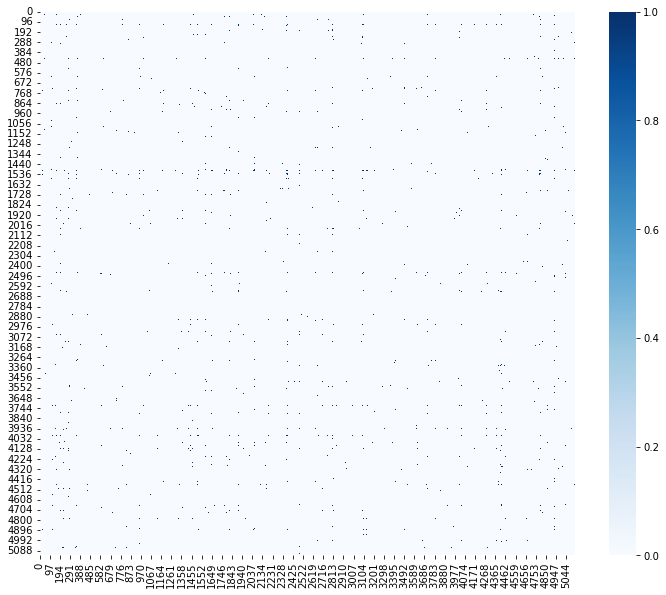

In [9]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
a_adj = adj_matrix_crs.toarray()
a_adj[a_adj>1] = 1
sns.heatmap(a_adj, cmap="Blues", ax=ax)
plt.show()

In [10]:
mobility_df.rename({'Sending Organization': 'source','Receiving Organization': 'target', 'Participants':'weight'},axis=1, inplace=True)
uni_cities = mobility_df.copy()
adj_matrix_crs, mobility_df, nodes_df = ns.keep_giant(ns.find_components(adj_matrix_crs, nodes_df), mobility_df)

### Degree distribution

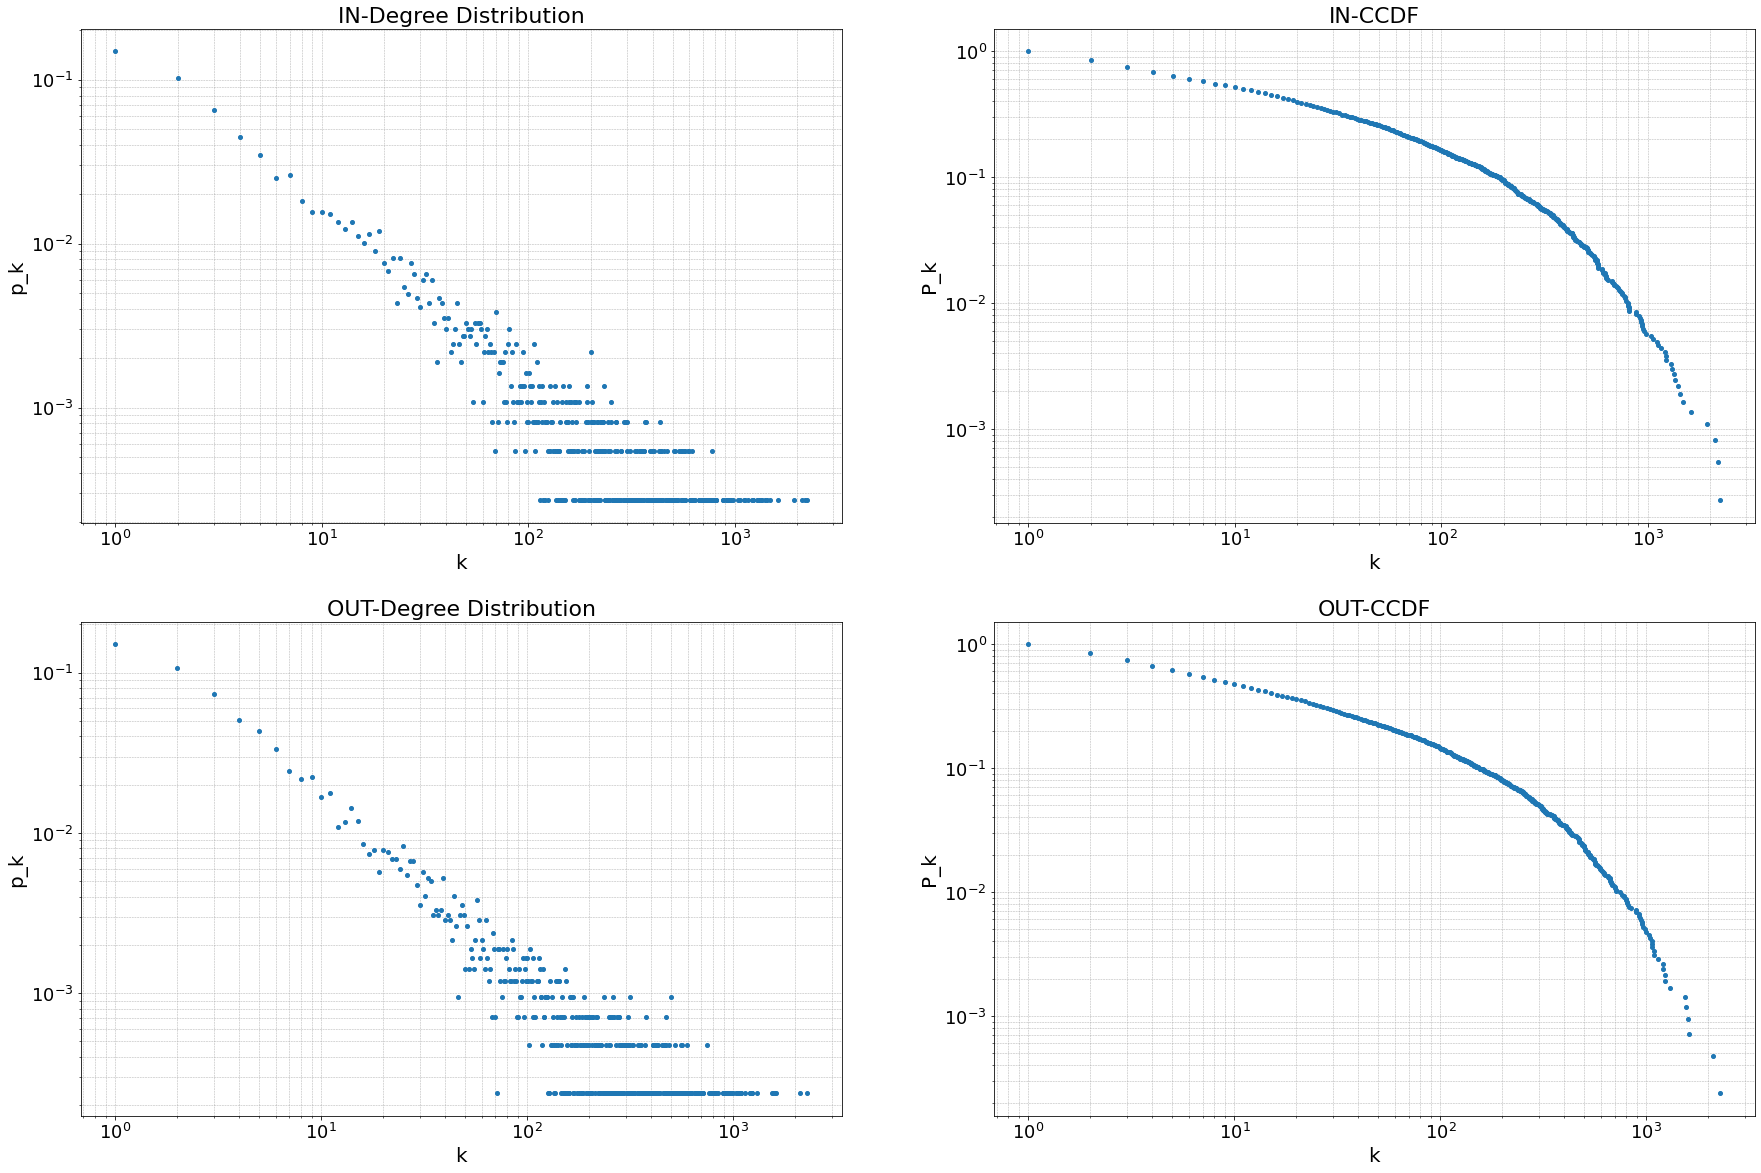

Top 10 for in degree


,Nodes,in degree
3147,UNIVERSITAT DE VALENCIA,2238
2746,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,2179
535,UNIVERSIDADE DE LISBOA,2118
510,UNIVERSIDAD DE GRANADA,1931
1335,UNIVERSIDAD COMPLUTENSE DE MADRID,1612
3328,UNIVERZA V LJUBLJANI,1481
524,UNIVERSITAT POLITECNICA DE VALENCIA,1434
4923,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,1405
2403,UNIVERSIDAD DE SEVILLA,1350
852,KATHOLIEKE UNIVERSITEIT LEUVEN,1341


Top 10 for out degree


,Nodes,out degree
2746,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,2280
510,UNIVERSIDAD DE GRANADA,2114
3147,UNIVERSITAT DE VALENCIA,1604
1335,UNIVERSIDAD COMPLUTENSE DE MADRID,1590
2278,UNIVERSITA DEGLI STUDI DI PADOVA,1563
2930,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,1544
3692,UNIVERSITA DEGLI STUDI DI TORINO,1299
535,UNIVERSIDADE DE LISBOA,1228
852,KATHOLIEKE UNIVERSITEIT LEUVEN,1225
3591,UNIVERSIDAD DEL PAIS VASCO/ EUSKAL HERRIKO UNI...,1203


In [11]:
scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
ns.display_top_n(scores, 10, 'in degree')
ns.display_top_n(scores, 10, 'out degree')

### Estimating $\gamma$ 

In [12]:
from collections import Counter
from statistics import mean

d_in = scores['in degree']
d_in = d_in[d_in>0]
d_out = scores['out degree']
d_out = d_out[d_out>0]
kmin = 100
d2_in = d_in[d_in>kmin]
d2_out = d_out[d_out>kmin]

sorted_d = sorted(d_in)
occurrence = Counter(sorted_d)
x_in = list(occurrence.keys())
y_in = list(occurrence.values())
y_in = y_in/np.sum(y_in)

sorted_d = sorted(d_out)
occurrence = Counter(sorted_d)
x_out = list(occurrence.keys())
y_out = list(occurrence.values())
y_out = y_out/np.sum(y_out)

Pk_in = 1 - np.cumsum(y_in)
Pk_in[-1] = 1 
Pk_in = sorted(Pk_in, reverse = True)
Pk_out = 1 - np.cumsum(y_out)
Pk_out[-1] = 1 
Pk_out = sorted(Pk_out, reverse = True)

In [13]:
ga_in = 1 + 1/mean(np.array(np.log(d2_in/kmin)))
ga_out = 1 + 1/mean(np.array(np.log(d2_out/kmin)))
C_in = (ga_in-1)*kmin**(ga_in-1) # normalization condition
C_out = (ga_out-1)*kmin**(ga_out-1)

pos_in = np.argmax(np.array(x_in)>=kmin)
pos_out = np.argmax(np.array(x_out)>=kmin)

P_kmin_in = Pk_in[pos_in] # constant value that shifts the line where the data are placed
pk_in = C_in*P_kmin_in*x_in**-ga_in
Pk_est_in = C_in*P_kmin_in*x_in**(-(ga_in-1))/(ga_in-1) 

P_kmin_out = Pk_out[pos_out] # constant value that shifts the line where the data are placed
pk_out = C_out*P_kmin_out*x_out**-ga_out
Pk_est_out = C_out*P_kmin_out*x_out**(-(ga_out-1))/(ga_out-1) 

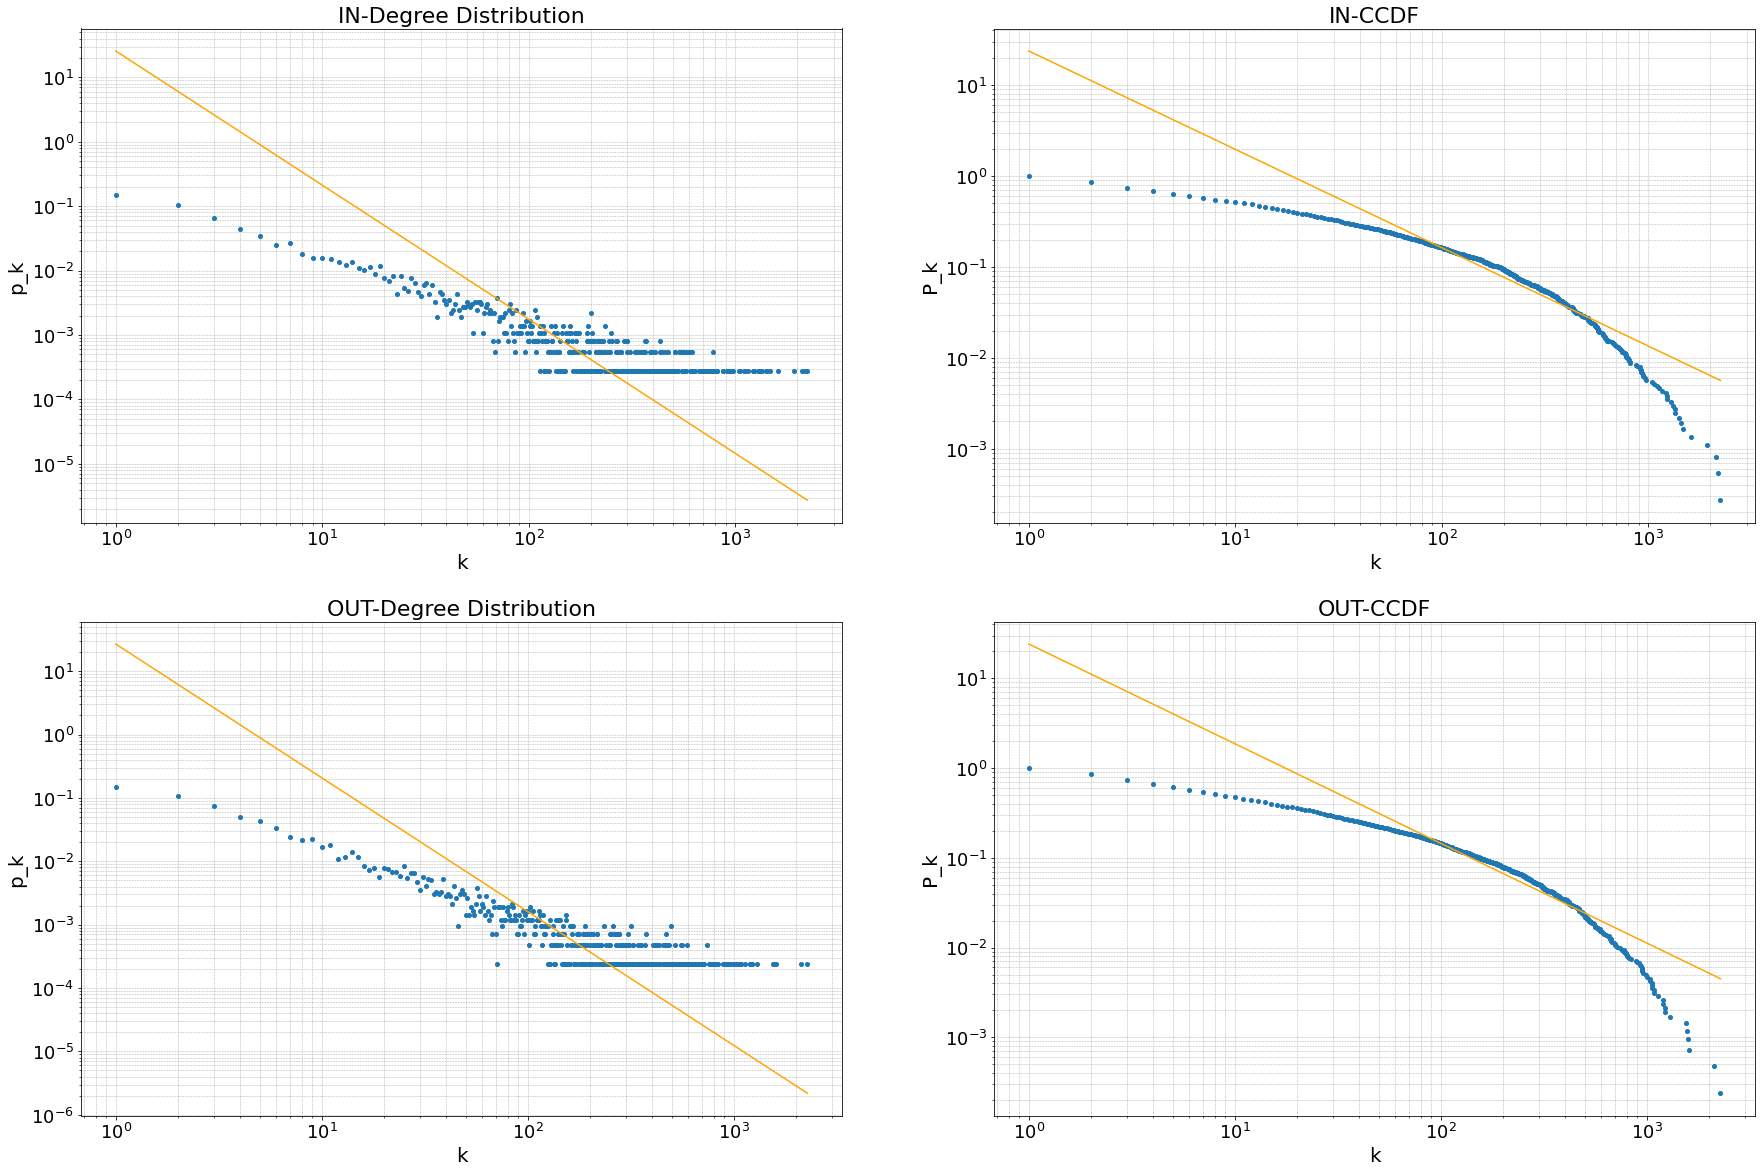

In [14]:
fig, ax = plt.subplots(2, 2, figsize = (30, 20))

def plot_gamma(ax, x, y, title, p, cumulative=False):
    ax.loglog(x, y, 'o', markersize = 4)
    ax.loglog(x, p, color='orange')
    ax.grid(which='both', linestyle='--', linewidth=0.5)
    ax.set_title(title, size = 22)
    ax.set_xlabel("k", size = 20)
    if cumulative:
        ax.set_ylabel("P_k", size = 20)
    else:
        ax.set_ylabel("p_k", size = 20)
    ax.tick_params(labelsize=18)
    ax.tick_params(labelsize=18)

plot_gamma(ax[0,0], x_in, y_in, "IN-Degree Distribution", pk_in)
plot_gamma(ax[0,1], x_in, Pk_in, "IN-CCDF", Pk_est_in, True)
plot_gamma(ax[1,0], x_out, y_out, "OUT-Degree Distribution", pk_out)
plot_gamma(ax[1,1], x_out, Pk_out, "OUT-CCDF", Pk_est_out, True)
plt.show()

### Estimating $\gamma$ through a linear fit with log binning

In [15]:
# Log binning 
nbins = 20
bins = np.logspace(0, 3.3, nbins)

hist_in = np.histogram(d_in, bins=bins, density=True)
hist_out = np.histogram(d_out, bins=bins, density=True)
logbin_p_k_in = hist_in[0]
logbin_p_k_out = hist_out[0]
middle_bins = np.sqrt( np.delete(bins, 0) * np.delete(bins, nbins-1) )

mask = np.log10(middle_bins) > np.log10(kmin)
x = np.log10( middle_bins[mask] )
y_in = np.log10( logbin_p_k_in[mask] )
y_out = np.log10( logbin_p_k_out[mask] )

# Linear fit
params_in = np.polyfit(x, y_in, deg =1)
params_out = np.polyfit(x, y_out, deg =1)
lin_gamma_in = -params_in[0]
lin_gamma_out = -params_out[0]

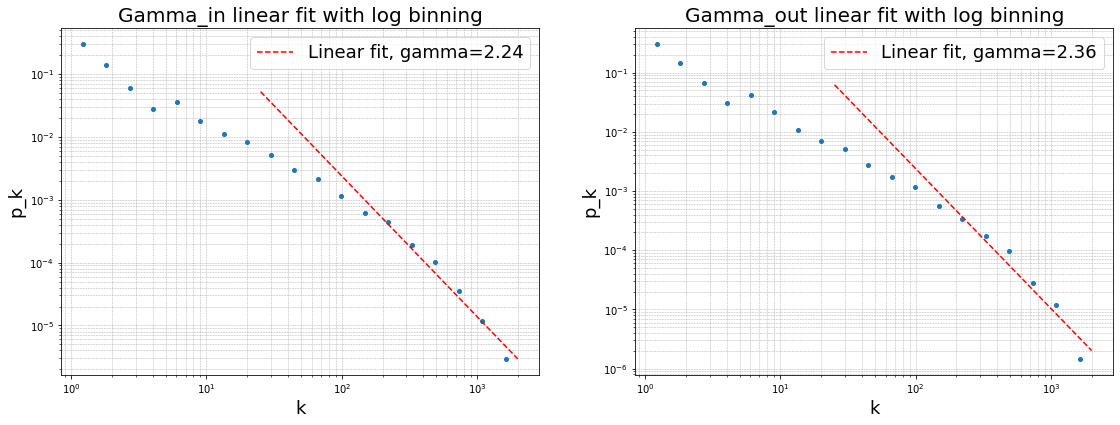

In [16]:
plt.figure(figsize=(60, 60))
plt.subplot(8, 6, 1)
plt.loglog(middle_bins, logbin_p_k_in , 'o', markersize = 4)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("Gamma_in linear fit with log binning", size = 20)
plt.xlabel("k", size = 18)
plt.ylabel("p_k", size = 18)
x2 = np.logspace(1.4,3.3,100)
y2 = np.full( 100, 10**(params_in[1])*x2**(-lin_gamma_in) ) 
plt.plot(x2,y2, label ="Linear fit, gamma="+str( np.round(lin_gamma_in,2) ), color="red", linestyle="--")
plt.legend(fontsize=18)

plt.subplot(8, 6, 2)
plt.loglog(middle_bins, logbin_p_k_out , 'o', markersize = 4)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("Gamma_out linear fit with log binning", size = 20)
plt.xlabel("k", size = 18)
plt.ylabel("p_k", size = 18)
x2 = np.logspace(1.4,3.3,100)
y2 = np.full( 100, 10**(params_out[1])*x2**(-lin_gamma_out) ) 
plt.plot(x2,y2, label ="Linear fit, gamma="+str( np.round(lin_gamma_out,2) ), color="red", linestyle="--")
plt.legend(fontsize=18)

plt.show()

### HITS (NetworkX)

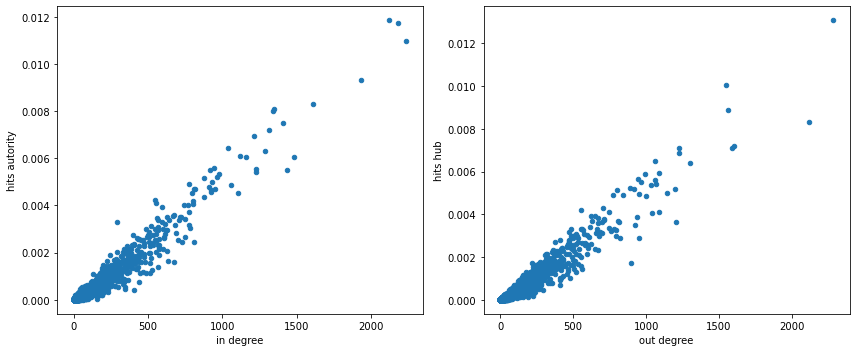

Top 10 for hits hub


,Nodes,hits hub
2746,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.013068
2930,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.010048
2278,UNIVERSITA DEGLI STUDI DI PADOVA,0.008881
510,UNIVERSIDAD DE GRANADA,0.008339
3147,UNIVERSITAT DE VALENCIA,0.007203
535,UNIVERSIDADE DE LISBOA,0.007114
1335,UNIVERSIDAD COMPLUTENSE DE MADRID,0.007107
852,KATHOLIEKE UNIVERSITEIT LEUVEN,0.006883
2361,TECHNISCHE UNIVERSITAET MUENCHEN,0.006487
3692,UNIVERSITA DEGLI STUDI DI TORINO,0.006378


Top 10 for hits autority


,Nodes,hits autority
535,UNIVERSIDADE DE LISBOA,0.011846
2746,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.011721
3147,UNIVERSITAT DE VALENCIA,0.010979
510,UNIVERSIDAD DE GRANADA,0.009306
1335,UNIVERSIDAD COMPLUTENSE DE MADRID,0.008310
2403,UNIVERSIDAD DE SEVILLA,0.008109
852,KATHOLIEKE UNIVERSITEIT LEUVEN,0.008007
4923,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,0.007508
2785,UNIVERZITA KARLOVA,0.007196
3529,UNIVERSITAT DE BARCELONA,0.006963


In [17]:
df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'hits hub')
ns.display_top_n(scores, 10, 'hits autority')

### PageRank (NetworkX)

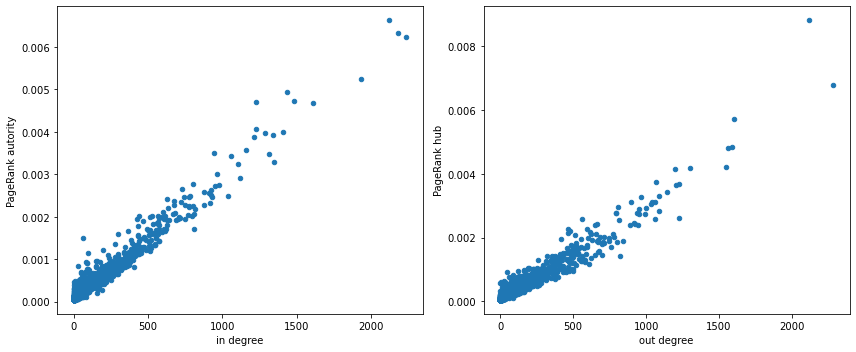

Top 10 for PageRank hub


,Nodes,PageRank hub
510,UNIVERSIDAD DE GRANADA,0.008810
2746,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.006786
3147,UNIVERSITAT DE VALENCIA,0.005716
1335,UNIVERSIDAD COMPLUTENSE DE MADRID,0.004823
2278,UNIVERSITA DEGLI STUDI DI PADOVA,0.004807
2930,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.004214
3692,UNIVERSITA DEGLI STUDI DI TORINO,0.004182
1792,UNIVERSIDAD POLITECNICA DE MADRID,0.004139
3328,UNIVERZA V LJUBLJANI,0.003745
535,UNIVERSIDADE DE LISBOA,0.003693


Top 10 for PageRank autority


,Nodes,PageRank autority
535,UNIVERSIDADE DE LISBOA,0.006626
2746,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.006335
3147,UNIVERSITAT DE VALENCIA,0.006226
510,UNIVERSIDAD DE GRANADA,0.005244
524,UNIVERSITAT POLITECNICA DE VALENCIA,0.004949
3328,UNIVERZA V LJUBLJANI,0.004723
4898,POLITECNICO DI MILANO,0.004714
1335,UNIVERSIDAD COMPLUTENSE DE MADRID,0.004670
2278,UNIVERSITA DEGLI STUDI DI PADOVA,0.004074
4923,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,0.003990


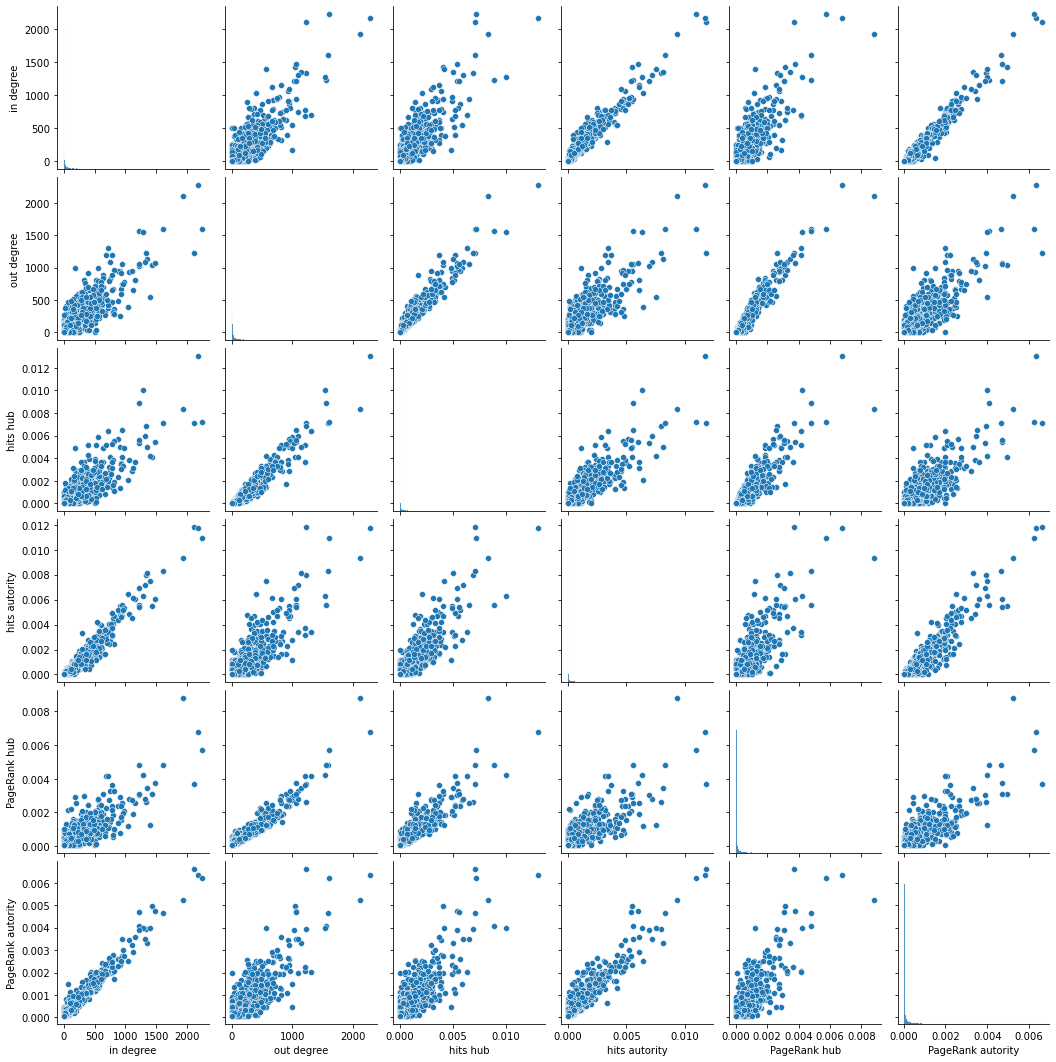

In [18]:
df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'PageRank hub')
ns.display_top_n(scores, 10, 'PageRank autority')
# ci vuole troppo a farlo
sns.pairplot(scores[['in degree', 'out degree',  'hits hub',
       'hits autority', 'PageRank hub', 'PageRank autority']])
plt.show()
# from IPython.display import Image
# Image('pairplot_score.png',)

### Assortativity

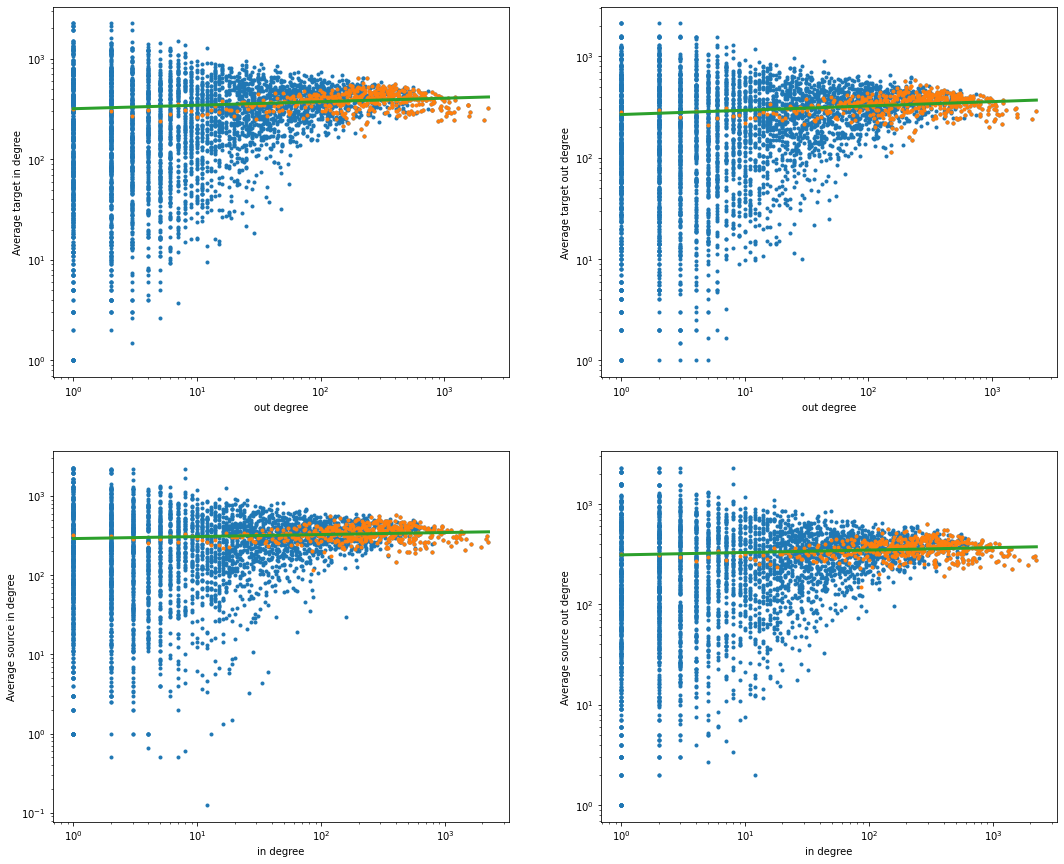

(0.034832263162413606,
 0.04243076951818893,
 0.025510101449321358,
 0.02403733513504581)

In [19]:
edges = mobility_df.copy()
ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True)

## Communities

In [20]:
import networkx as nx

G = nx.convert_matrix.from_scipy_sparse_matrix(adj_matrix_crs)
p = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)
node_comm = nodes_df.copy()
node_comm.drop(columns=['NodeID'], inplace=True)

node_comm['Community']=np.zeros(len(node_comm.index),dtype='int8')
for i, set in enumerate(p):
    for element in set:
        node_comm.iat[element, 1]=i
for i, set in enumerate(p):
    display(node_comm[node_comm['Community']==i])
    
scores['uni_Community'] = node_comm['Community']
# 52 communities. Choose if it makes sense to reduce the number of them 

,Nodes,Community
2,OCTOBER 6 UNIVERSITY,0
3,NYUGAT-MAGYAROSZÁGI EGYETEM,0
4,SEINAJOEN AMMATTIKORKEAKOULU OY,0
6,ECOLE DES BEAUX-ARTS DE NANTES SAINT-NAZAIRE,0
7,AZERBAIJAN UNIVERSITY LIMITED LIABILITY COMPANY,0
...,...,...
5086,WYZSZA SZKOLA TURYSTYKI I EKOLOGII,0
5089,TIRANA BUSINESS UNIVERSITY,0
5090,TECHNISCHE HOCHSCHULE NURNBERG GEORG SIMON OHM,0
5093,JINGGANGSHAN UNIVERSITY,0


,Nodes,Community
1,MONTCLAIR STATE UNIVERSITY,1
12,HEINRICH-HEINE-UNIVERSITAET DUESSELDORF,1
15,UNIVERSITE DE STRASBOURG,1
20,UNIVERSITA DEGLI STUDI DI NAPOLI L'ORIENTALE,1
22,WASEDA UNIVERSITY,1
...,...,...
5075,HASKOLI ISLANDS,1
5083,LEBANESE AMERICAN UNIVERSITY,1
5084,NATIONAL PEDAGOGICAL DRAGOMANOV UNIVERSITY,1
5091,VICTORIA UNIVERSITY,1


,Nodes,Community
0,ZHETYSU STATE UNIVERSITY NAMED AFTER I.ZHANSUG...,2
8,UNIVERSITE DE SAINT ESPRIT-KASLIK AUTORITE REL...,2
9,ISTANBUL KEMERBURGAZ UNIVERSITESI,2
10,ECOLE CENTRALE DE NANTES,2
16,ARAB INTERNATIONAL UNIVERSITY,2
...,...,...
5078,"NATIONAL UNIVERSITY ""OSTROH ACADEMY""",2
5079,SHIBAURA INSTITUTE OF TECHNOLOGY,2
5092,UNIVERSITE IBNOU ZOHR A AGADIR,2
5096,UNIVERSITE FELIX HOUPHOUET BOIGNY,2


,Nodes,Community
5,SHENYANG AGRICULTURAL UNIVERSITY,3
41,CARLETON UNIVERSITY,3
90,KAGOSHIMA UNIVERSITY,3
94,POLYTECHNIQUE MONTREAL,3
126,ECOLE POLYTECHNIQUE D'ARCHITECTURE ET D'URBANISME,3
...,...,...
4874,INSTITUT SUPERIEUR DE MECANIQUE DE PARIS,3
4910,NOTRE DAME UNIVERSITY - LOUAIZE,3
4968,UNIVERSIDADE FEDERAL DO RIO GRANDE DO SUL,3
5022,UNIVERSIDAD SAN CARLOS,3


,Nodes,Community
238,HELMUT SCHMIDT UNIVERSITAT UNIVERSITAT DER BUN...,4
324,AKADEMIA WOJSK LADOWYCH IMIENIA GENERALA TADEU...,4
331,SISEKAITSEAKADEEMIA,4
417,UNIVERSITY OF NORTH GEORGIA,4
420,UNIVERZITA OBRANY,4
...,...,...
4708,ECOLE ROYALE MILITAIRE - KONINKLIJKE MILITAIRE...,4
4744,GENEROLO JONO ZEMAICIO LIETUVOS KARO AKADEMIJA,4
4749,HOCHSCHULE FÜR POLIZEI UND ÖFFENTLICHE VERWALT...,4
4966,HELLENIC ARMY ACADEMY,4


,Nodes,Community
68,I-SHOU UNIVERSITY,5
826,FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,5
1123,RUSSIAN-ARMENIAN (SLAVONIC) UNIVERSITY STATE A...,5
1178,UNIVERSITY OF NIS,5
1515,D. A. TSENOV ACADEMY OF ECONOMICS,5
...,...,...
3757,SHOTA RUSTAVELI STATE UNIVERSITY,5
3813,UNIVERSIDAD DE ORIENTE,5
4101,ODESSA NATIONAL ECONOMIC UNIVERSITY,5
4345,VADYM HETMAN KYIV NATIONAL ECONOMIC UNIVERSITY,5


,Nodes,Community
11,ASSOCIATION SAINTE ANNE,6
88,NEWMANINSTITUTET,6
1016,PANSTWOWA MEDYCZNA WYZSZA SZKOLA ZAWODOWA W OPOLU,6
1266,PHILOSOPHISCH THEOLOGISCHE HOCHSCHULE SANKT GE...,6
1383,UNIVERSITY COLLEGE SYDDANMARK,6
...,...,...
3399,PAPIESKI WYDZIAL TEOLOGICZNY WE WROCLAWIU,6
4111,ERASME,6
4469,"PONTIFICAL UNIVERSITY, ST PATRICK'S COLLEGE MA...",6
4681,KATHOLISCHE HOCHSCHULE MAINZ,6


,Nodes,Community
265,BALTIC STATE TECHNICAL UNIVERSITY VOENMEKH NAM...,7
440,MOSCOW STATE INSTITUTE OF INTERNATIONAL RELATI...,7
889,FEDERAL STATE BUDGETARY EDUCATIONAL INSTITUTIO...,7
1543,FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,7
1658,KOREA UNIVERSITY,7
...,...,...
4163,DIPLOMATISCHE AKADEMIE WIEN,7
4482,FEDERAL STATE BUDGETARY EDUCATIONAL INSTITUTIO...,7
4506,PÄDAGOGISCHE HOCHSCHULE SALZBURG,7
4669,ILISIMATUSARFIK,7


,Nodes,Community
374,UNIWERSYTET PAPIESKI JANA PAWLA II W KRAKOWIE,8
426,CAUCASUS UNIVERSITY LTD,8
1930,NATIONAL UNIVERSITY OF MANAGEMENT,8
1961,LATVIJAS KRISTIGA AKADEMIJA,8
1973,SV.IGNACO LOJOLOS KOLEGIJA,8
...,...,...
2483,VIESOJI ISTAIGA KOLPINGO KOLEGIJA,8
3567,LCC INTERNATIONAL UNIVERSITY,8
3715,HIGHER EDUCATIONAL ESTABLISHMENT UKRAINIAN CAT...,8
4568,PROTESTANTSE THEOLOGISCHE UNIVERSITEIT,8


,Nodes,Community
167,TITU MAIORESCU UNIVERSITY,9
206,SIGMUND FREUD PRIVATUNIVERSITAT WIEN GMBH,9
1357,UCZELNIA PAŃSTWOWA IM. JANA GRODKA W SANOKU,9
1986,PRIVATE UNIVERSITY OF KALAMOON,9
2038,VISSHE UCHILISHTE MEZHDUNARODEN KOLEZH,9
...,...,...
3247,PANSTWOWA WYZSZA SZKOLA ZAWODOWA IM. JANA GROD...,9
3990,CANAKKALE ONSEKIZ MART UNIVERSITESI,9
4279,AL-WATANIYA PRIVATE UNIVERSITY,9
4365,KARKONOSKA PANSTWOWA SZKOLA WYZSZA W JELENIEJ ...,9


,Nodes,Community
898,VIESOJI ISTAIGA EUROPOS HUMANITARINIS UNIVERSI...,10
1738,THE UNIVERSITY OF BUCKINGHAM,10
1977,S. TORAIGHYROV PAVLODAR STATE UNIVERSITY OF TH...,10
2605,AMERICAN UNIVERSITY OF CENTRAL ASIA INSTITUTION,10
2771,DUALE HOCHSCHULE BADEN-WÜRTTEMBERG VILLINGEN-S...,10
...,...,...
3335,SAMI SHAMOON COLLEGE OF ENGINEERING(R.A.) FRIE...,10
3897,NEUMANN JÁNOS EGYETEM,10
4058,FEDERAL STATE BUDGETARY EDUCATIONAL INSTITUTIO...,10
4523,FREDERICK UNIVERSITY FU,10


,Nodes,Community
114,VSTVS PALESTRA,11
127,TESTNEVELESI EGYETEM,11
1252,LATVIJAS SPORTA PEDAGOGIJAS AKADEMIJAS,11
2263,BEIJING SPORT UNIVERSITY,11
2710,SLIPPERY ROCK UNIVERSITY OF PENNSYLVANIA,11
3204,BELARUSIAN STATE UNIVERSITY OF PHYSICAL CULTURE,11
3374,GYMNASTIK- OCH IDROTTSHÖGSKOLAN,11
3995,"FACULTY OF SPORT AND PHYSICAL EDUCATION, UNIVE...",11
4400,DEUTSCHE SPORTHOCHSCHULE KOLN,11
4491,NATSIONALNA SPORTNA AKADEMIYA VASSIL LEVSKI,11


,Nodes,Community
306,AUGUSTANA-HOCHSCHULE,12
598,FULLER THEOLOGICAL SEMINARY,12
731,DET TEOLOGISKE MENIGHETSFAKULTET,12
1507,DEBRECENI REFORMÁTUS HITTUDOMÁNYI EGYETEM,12
1862,THEOLOGISCHE UNIVERSITEIT VAN DE GEREFORMEERDE...,12
2706,PROTESTANT THEOLOGICAL INSTITUTE OF CLUJ-NAPOCA,12
3060,SÁROSPATAKI REFORMÁTUS TEOLÓGIAI AKADÉMIA,12
4147,EVANGÉLIKUS HITTUDOMÁNYI EGYETEM,12


,Nodes,Community
291,ACCADEMIA NAZIONALE DI DANZA,13
453,PALESTINIAN CIRCUS,13
482,CONSERVATORIO SUPERIOR DE DANZA DE ALICANTE,13
1037,FIRST RAMALLAH GROUP ASSOCIATION,13
1599,MAGYAR TANCMUVESZETI EGYETEM,13
3935,DONKO SEKO,13
4711,CONSERVATORIO SUPERIOR DE DANZA DE VALENCIA,13


,Nodes,Community
252,IES HOTEL ESCUELA,14
691,SOUTH WEST COLLEGE,14
1158,HIGHER HOTEL INSTITUTE CYPRUS (HHIC),14
1179,CENTRO INTEGRAL DE FP ILERNA S.L.,14
2300,LYCÉE DES MÉTIERS DE L'HÔTELLERIE ET DU TOURIS...,14
2792,CENTRE INTEGRAL DE FP ILERNA S.L.,14
5062,IES MARIA DE ZAYAS Y SOTOMAYOR,14


,Nodes,Community
388,INSTITUTIA PUBLICA ACADEMIA DE MUZICA TEATRU S...,15
831,UNIVERSIDAD NACIONAL DE GENERAL SAN MARTIN,15
1427,CONSERVATORIO SUPERIOR DE MÚSICA DE CASTILLA-L...,15
3588,SONCA INTERNATIONAL/MUSIARTE,15
4007,CONSERVATORIO STATALE DI MUSICA A.STEFFANI,15
4334,"CONSERVATORIO DI MUSICA DI STATO ""ANTONIO SCON...",15


,Nodes,Community
555,FACHHOCHSCHULE COBURG,16
2290,ISLAMIC UNIVERSITY OF APPLIED SCIENCES ROTTERDAM,16
3532,UNIVERSITE ALQUARAOUIYINE,16
3782,INTERNATIONAL CENTRE FOR EDUCATION IN ISLAMIC ...,16
4909,ISTANBUL SABAHATTIN ZAIM UNIVERSITY,16
5088,UNIVERSITE EZ-ZITOUNA,16


,Nodes,Community
705,SAINT PETERSBURG ELECTROTECHNICAL UNIVERSITY LETI,17
1259,DALIAN NATIONALITIES UNIVERSITY,17
2875,TAYLOR'S UNIVERSITY MALAYSIA,17
3291,ERHVERVSAKADEMI SJÆLLAND,17
3378,UNIVERSIDAD FINIS TERRAE,17


,Nodes,Community
1560,SIHE I. HORBACHEVSKY TERNOPIL STATE MEDICAL UN...,18
1873,PANSTWOWA SZKOLA WYZSZA IM PAPIEZA JANA PAWLA ...,18
1985,BREST STATE UNIVERSITY NAMED AFTER A.S. PUSHKI...,18
2686,INSTITUTO POLITÉCNICO DE GESTÃO E TECNOLOGIA -...,18
4544,UNIVERZITET ZA TURIZAM I MENAGMENT VO SKOPJE,18


,Nodes,Community
469,FEDERAL STATE BUDGETARY EDUCATIONAL INSTITUTIO...,19
548,MOSCOW REGION STATE UNIVERSITY,19
4330,SPRACHEN- UND DOLMETSCHER-INSTITUTMUNCHEN EV,19
4477,QINGDAO UNIVERSITY,19
4946,STATE EDUCATION INSTITUTION OF HIGHER PROFESSI...,19


,Nodes,Community
2231,ZHEJIANG CHINESE MEDICAL UNIVERSITY,20
2579,GGTU,20
3030,UNIVERSITATEA DE VEST VASILE GOLDIS DIN ARAD,20
3848,ZHEJIANG UNIVERSITY OF SCIENCE AND TECHNOLOGY,20


,Nodes,Community
2748,HAUTE ECOLE EN HAINAUT,21
3162,ASSOCIATION RÉGIONALE POUR LA FORMATION PLURIP...,21
4590,ARFIS OI,21
4878,GROUPE 3IL,21


,Nodes,Community
581,NYIREGYHAZI EGYETEM,22
3916,PAPAI REFORMATUS TEOLOGIAI AKADEMIA,22
3949,UNIVERZITA J. SELYEHO,22
4939,VISOKO UCILISTE ALGEBRA - VISOKA SKOLA ZA PRIM...,22


,Nodes,Community
249,KYIV THEOLOGICAL ACADEMY AND SEMINARY OF UKRAI...,23
3449,ANOTATI ECCLESIASTIKI AKADEMIA THESSALONIKIS,23
3632,RELIGIOUS ORGANIZATION OF HIGHER THEOLOGICAL E...,23


,Nodes,Community
2342,SHANGHAI JIAN QIAO UNIVERSITY,24
3314,UNIVERSITATEA DE ARTA SI DESIGN DINCLUJ-NAPOCA,24
3781,NORTHERN MICHIGAN UNIVERSITY,24


,Nodes,Community
1532,BUDAPEST KORTARSTANC FOISKOLA,25
2662,KEMEROVO STATE UNIVERSITY OF CULTURE,25
4194,THE JERUSALEM ACADEMY OF MUSIC AND DANCE,25


,Nodes,Community
419,VYSOKA SKOLA MEDZINARODNEHO PODNIKANIA ISM SLO...,26
2755,VYSOKA SKOLA EKONOMIE A MANAGEMENTU OPS,26
4552,PANSTWOWA WYZSZA SZKOLA ZAWODOWA W CHELMIE,26


,Nodes,Community
794,"VISOKA SKOLA ""CEPS - CENTAR ZA POSLOVNE STUDIJ...",27
1991,MARIN BARLETI SHA,27
4623,IES RIBEIRA DO LOURO,27


,Nodes,Community
2149,PÔLE SUPÉRIEUR D'ENSEIGNEMENT ARTISTIQUE PARIS...,28
2788,ANTON BRUCKNERPRIVATUNIVERSITAT,28
5023,NORGES DANSEHØYSKOLE,28


,Nodes,Community
1000,HOGSKOLEN I HEDMARK,29
1905,BISHOP GROSSETESTE UNIVERSITY COLLEGE LINCOLN,29


,Nodes,Community
1240,HOCHSCHULE OSTWESTFALEN-LIPPE,30
2333,KOREA NATIONAL UNIVERSITY OF ARTS,30


,Nodes,Community
2316,GEORGIAN INSTITUTE OF PUBLIC AFFAIR FOUNDATION,31
2424,NLA HØGSKOLEN,31


,Nodes,Community
2321,SCUOLA SUPERIORE DI STUDI UNIVERSITARI E DI PE...,32
2751,ADDIS ABABA UNIVERSITY,32


,Nodes,Community
1428,ESCOLA SUPERIOR DE EDUCAÇÃO DE FAFE,33
2817,AMASYA UNIVERSITESI,33


,Nodes,Community
3537,AUTOGRAF,34
3863,FREE UNIVERSITY OF TBILISI,34


,Nodes,Community
2372,PROFESSIONHOJSKOLEN I REGION SJAELLAND,35
4055,STIFTUNG PRIVATE PÄDAGOGISCHE HOCHSCHULE BURGE...,35


,Nodes,Community
3488,INSTITUT POBLENOU,36
4191,LYCEE AMPERE,36


,Nodes,Community
3281,ESCA ECOLE DE MANAGEMENT,37
4223,RIGAS STARPTAUTISKA EKONOMIKAS UN BIZNESA ADMI...,37


,Nodes,Community
2759,CONSERVATOIRE NATIONAL SUPÉRIEUR D'ART DRAMATIQUE,38
4246,HOCHSCHULE FÜR SCHAUSPIELKUNST ERNST BUSCH,38


,Nodes,Community
46,PANSTWOWA WYZSZA SZKOLA ZAWODOWA IM. HIPOLITA ...,39
4677,PAVLO TYCHYNA UMAN STATE PEDAGOGICAL UNIVERSITY,39


,Nodes,Community
1804,LYCEE DE L'HOTELLERIE ET DU TOURISME GEORGES F...,40
4737,SSML GREGORIO VII,40


,Nodes,Community
1557,VELEUCILISTE U BJELOVARU,41
4830,"VISOKA MEDICINSKA SKOLA STRUKOVNIH STUDIJA ""MI...",41


,Nodes,Community
4095,"SVEUČILIŠTE/UNIVERZITET ""VITEZ"" VITEZ",42
4847,COLLEGE OF APPLIED SCIENCES LAVOSLAV RUZICKA I...,42


,Nodes,Community
1260,BELARUSKI DZIARZHAUNY PEDAGOGICHNYUNIVERSITET ...,43
5015,PADAGOGISCHE HOCHSCHULE OBEROSTERREICH,43


,Nodes,Community
3624,"FACULTY OF EDUCATION, UNIVERSITY OF KRAGUJEVAC",44
5087,EOTVOS JOZSEF FOISKOLA,44


,Nodes,Community
733,FUNDACION UNIVERSIDAD DE LAS AMERICAS PUEBLA,45


## Geographical heatmap

In [21]:
temp_df = uni_cities[['target', 'Receiving City']].copy()
temp_df.rename({'target':'source', 'Receiving City':'Sending City'},axis=1, inplace=True)
cities_uni = pd.concat([uni_cities[['source', 'Sending City']], temp_df]).drop_duplicates().reset_index(drop=True)

for index in range(cities_uni.shape[0]):
    city = cities_uni.iat[index,1]
    if city != city.upper():
        cities_uni.iat[index,1] = city.upper()
cities_uni = cities_uni.drop_duplicates().reset_index(drop=True)
cities_uni = cities_uni.drop_duplicates(subset='source').reset_index(drop=True)

# assigning cities to each university in scores
cities_list = []
for u in scores['Nodes']:
    cities_list.append(list(cities_uni.loc[cities_uni['source'] == u, 'Sending City'])[0])

scores_cities = scores.copy()
scores_cities['City'] = cities_list

scores_cities

,Nodes,NodeID_x,in degree,out degree,NodeID_y,hits hub,hits autority,NodeID,PageRank hub,PageRank autority,uni_Community,City
0,ZHETYSU STATE UNIVERSITY NAMED AFTER I.ZHANSUG...,0,0,1,0,0.000006,0.000000,0,0.000048,0.000043,2,TOLDYKORGAN
1,MONTCLAIR STATE UNIVERSITY,1,3,2,1,0.000007,0.000014,1,0.000051,0.000051,1,MONTCLAIR
2,OCTOBER 6 UNIVERSITY,2,0,1,2,0.000001,0.000000,2,0.000047,0.000043,0,OCTOBER 6 CITY
3,NYUGAT-MAGYAROSZÁGI EGYETEM,3,4,0,3,0.000000,0.000006,3,0.000045,0.000056,0,SOPRON
4,SEINAJOEN AMMATTIKORKEAKOULU OY,4,192,41,4,0.000033,0.000209,4,0.000333,0.000463,0,SEINAJOKI
...,...,...,...,...,...,...,...,...,...,...,...,...
5094,HOCHSCHULE FÜR GESTALTUNG SCHWÄBISCH GMÜND,5094,19,33,5094,0.000064,0.000048,5094,0.000151,0.000216,0,SCHWÄBISCH GMÜND
5095,NEMZETI KOZSZOLGALATI EGYETEM,5095,102,109,5095,0.000273,0.000280,5095,0.000430,0.000621,4,BUDAPEST
5096,UNIVERSITE FELIX HOUPHOUET BOIGNY,5096,0,3,5096,0.000017,0.000000,5096,0.000053,0.000043,2,ABIDJAN
5097,UNIVERSITE D'ORLEANS,5097,123,216,5097,0.001092,0.000459,5097,0.000512,0.000315,1,ORL�ANS


In [22]:
city_coord = pd.read_csv('worldcities.csv', encoding='utf8')
city_coord.drop(columns=['capital', 'population', 'id', 'iso3', 'country'], inplace=True)
for index in range(city_coord.shape[0]):
    city = city_coord.iat[index,0]
    if city != city.upper():
        city_coord.iat[index,0] = city.upper()
city_coord = city_coord.drop_duplicates().reset_index(drop=True)
scores_cities = pd.merge(left=scores_cities, right=city_coord, how='left', left_on='City', right_on='city')
scores_cities.dropna(subset=['city'], inplace=True)
scores_cities = scores_cities.drop_duplicates(subset='Nodes').reset_index(drop=True)
scores_cities

# some cities are missing like Milano, Torino, Madrid (these are also pretty much important)

,Nodes,NodeID_x,in degree,out degree,NodeID_y,hits hub,hits autority,NodeID,PageRank hub,PageRank autority,uni_Community,City,city,city_ascii,lat,lng,iso2,admin_name
0,MONTCLAIR STATE UNIVERSITY,1,3,2,1,7.096828e-06,0.000014,1,0.000051,0.000051,1,MONTCLAIR,MONTCLAIR,Montclair,34.0714,-117.6980,US,California
1,NYUGAT-MAGYAROSZÁGI EGYETEM,3,4,0,3,0.000000e+00,0.000006,3,0.000045,0.000056,0,SOPRON,SOPRON,Sopron,47.6833,16.5833,HU,Sopron
2,SHENYANG AGRICULTURAL UNIVERSITY,5,0,2,5,7.562448e-09,0.000000,5,0.000057,0.000043,3,SHENYANG,SHENYANG,Shenyang,41.8039,123.4258,CN,Liaoning
3,ECOLE DES BEAUX-ARTS DE NANTES SAINT-NAZAIRE,6,0,6,6,3.096920e-05,0.000000,6,0.000075,0.000043,0,NANTES,NANTES,Nantes,47.2181,-1.5528,FR,Pays de la Loire
4,AZERBAIJAN UNIVERSITY LIMITED LIABILITY COMPANY,7,0,5,7,1.174978e-06,0.000000,7,0.000082,0.000043,0,BAKU,BAKU,Baku,40.3667,49.8352,AZ,Bakı
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3519,TIRANA BUSINESS UNIVERSITY,5089,0,2,5089,1.296231e-07,0.000000,5089,0.000048,0.000043,0,TIRANA,TIRANA,Tirana,41.3300,19.8200,AL,Tiranë
3520,UNIVERSITE IBNOU ZOHR A AGADIR,5092,3,16,5092,3.328992e-05,0.000005,5092,0.000089,0.000052,2,AGADIR,AGADIR,Agadir,30.4167,-9.5833,MA,Souss-Massa
3521,HOCHSCHULE FÜR GESTALTUNG SCHWÄBISCH GMÜND,5094,19,33,5094,6.383141e-05,0.000048,5094,0.000151,0.000216,0,SCHWÄBISCH GMÜND,SCHWÄBISCH GMÜND,Schwabisch Gmund,48.8000,9.8000,DE,Baden-Württemberg
3522,NEMZETI KOZSZOLGALATI EGYETEM,5095,102,109,5095,2.726697e-04,0.000280,5095,0.000430,0.000621,4,BUDAPEST,BUDAPEST,Budapest,47.4983,19.0408,HU,Budapest


Importing geographic data also for countries

In [23]:
import geopandas as gpd
import pycountry as pc #library used for translating country codes from iso3 to iso2 standard

geo_df = gpd.read_file('countries.geojson')

def replace_iso2(alpha):
    try:
        return pc.countries.get(alpha_3=alpha).alpha_2
    except:
        return alpha
    
geo_df['iso2_code']= (np.array(list(map(lambda x: replace_iso2(x), geo_df['ISO_A3']))))

geo_df.columns = ['country', 'country_code', 'geometry', 'iso2_code']

# in geo_df United Kingdom has code GB, so we have to change it manually
geo_df.loc[geo_df['country'] == 'United Kingdom', 'iso2_code'] = 'UK'
geo_df.loc[geo_df['country'] == 'Greece', 'iso2_code'] = 'EL'
geo_df.loc[geo_df['country'] == 'Kosovo', 'iso2_code'] = 'XK'
geo_df.loc[geo_df['country'] == 'Czech Republic', 'country'] = 'Czechia'
geo_df.loc[geo_df['country'] == 'Republic of Serbia', 'country'] = 'Serbia'

# merge geometries with our dataframe
geo_scores = pd.merge(left=scores_cities, right=geo_df[['iso2_code', 'geometry']], how='left', 
                      left_on='iso2', right_on='iso2_code')
geo_scores = geo_scores[['Nodes', 'PageRank hub', 'PageRank autority', 'City', 'lat', 'lng',
                         'iso2', 'geometry', 'uni_Community']]

Dividing universities by their country community

In [24]:
import networkx as nx

### 1 create the network of countries only
country_df = c_df[c_df[c_df.columns[10]]=='Learner']
country_df = country_df.loc[:, c_df.columns[np.array((14, 17, 20))]]
country_df.dropna(how='any', inplace=True)

# c_nodes = np.array(list(set.union(set(country_df.loc[:, country_df.columns[0]]), set(country_df.loc[:, country_df.columns[1]]))))
c_nodes = np.array(list(pd.concat([country_df.loc[:, country_df.columns[0]], country_df.loc[:, country_df.columns[1]]]).drop_duplicates()))
country_df.dropna(how='any', inplace=True)

c_node_position = {}
for i, name in enumerate(c_nodes):
    c_node_position[name] = i
country_nodes= pd.DataFrame({'Nodes': c_nodes})
country_df['SendId'] = (np.array(list(map(lambda x: c_node_position[x], country_df['Sending Country Code']))))
country_df['RecId'] = (np.array(list(map(lambda x: c_node_position[x], country_df['Receiving Country Code']))))
# Adjacency matrix
country_serie = country_df.groupby(['SendId', 'RecId']).sum()
row = np.array(country_serie.index.get_level_values(1).tolist())
col = np.array(country_serie.index.get_level_values(0).tolist())
val = country_serie.values
c_adj_matrix = sparse.csr_matrix((val.flatten(), (row, col)), shape=(c_nodes.size, c_nodes.size))

### 2 countries community
G_country = nx.convert_matrix.from_scipy_sparse_matrix(c_adj_matrix)
p_c = nx.algorithms.community.modularity_max.greedy_modularity_communities(G_country)
country_comm = country_nodes.copy()

country_comm['Community']=np.zeros(len(country_comm.index),dtype='int8')
for i, set in enumerate(p_c):
    for element in set:
        country_comm.iat[element, 1]=i
for i, set in enumerate(p_c):
    display(country_comm[country_comm['Community']==i])

geo_scores = pd.merge(left=geo_scores, right=country_comm, how='left', left_on='iso2', right_on='Nodes')

,Nodes,Community
1,AT,0
4,KR,0
9,CA,0
16,US,0
17,UG,0
...,...,...
125,IR,0
133,BW,0
137,BT,0
143,VE,0


,Nodes,Community
2,UA,1
3,RU,1
5,RS,1
7,IL,1
8,PS,1
...,...,...
120,AF,1
122,SD,1
126,RW,1
134,LY,1


,Nodes,Community
6,ET,2
11,AU,2
12,NZ,2
21,NP,2
30,UZ,2
...,...,...
136,AO,2
138,IQ,2
139,MR,2
141,SR,2


,Nodes,Community
0,PT,3
23,IN,3
26,TN,3
34,JO,3
58,TZ,3
...,...,...
112,NO,3
115,TL,3
116,LA,3
117,SE,3


,Nodes,Community
24,BE,4
61,CM,4
104,LI,4
127,CD,4
128,NI,4
146,CH,4


Focus on european countries

In [25]:
eu_countries = ['Germany', 'United Kingdom', 'France', 'Italy', 'Spain', 'Ukraine', 'Poland', 'Romania', 
                'Netherlands', 'Belgium', 'Czechia', 'Greece', 'Portugal', 'Sweden', 'Hungary', 
                'Belarus', 'Austria', 'Serbia', 'Switzerland', 'Bulgaria', 'Denmark', 'Finland', 'Slovakia', 'Norway',
                'Ireland', 'Croatia', 'Moldova', 'Bosnia and Herzegovina', 'Albania', 'Lithuania', 'Macedonia', 
                'Slovenia', 'Latvia', 'Estonia', 'Montenegro', 'Luxembourg', 'Malta', 'Iceland', 'Andorra', 'Monaco', 
                'Liechtenstein', 'Kosovo', 'Turkey']

def replace_iso3166(alpha):
    try:
        return pc.countries.get(name=alpha).alpha_2
    except:
        return alpha
    
eu_countries_iso2 = list(map(lambda x: replace_iso3166(x), eu_countries))

geo_scores = geo_scores[geo_scores['iso2'].isin(eu_countries_iso2)]

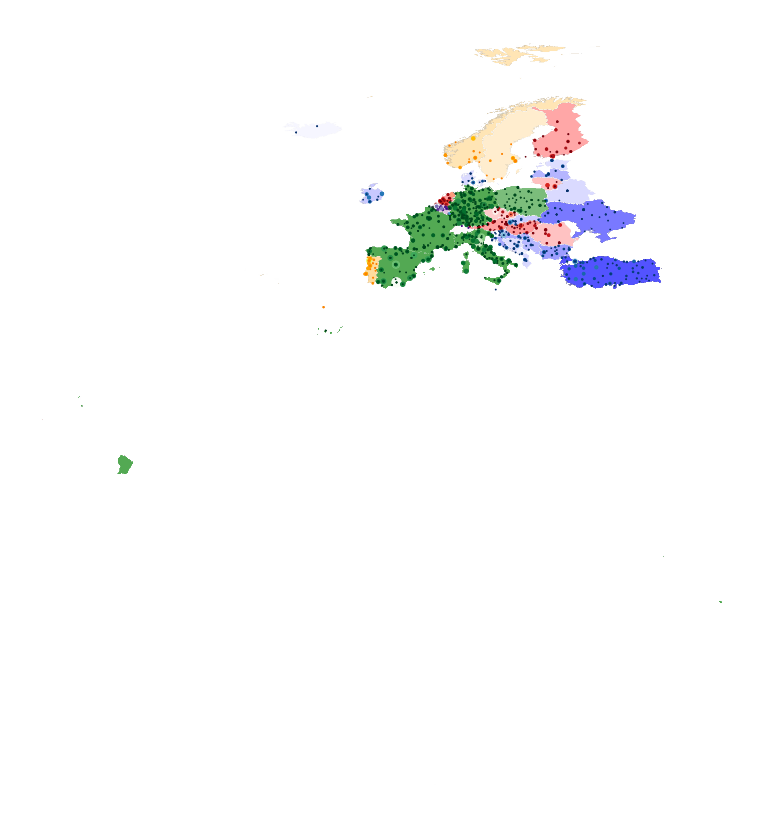

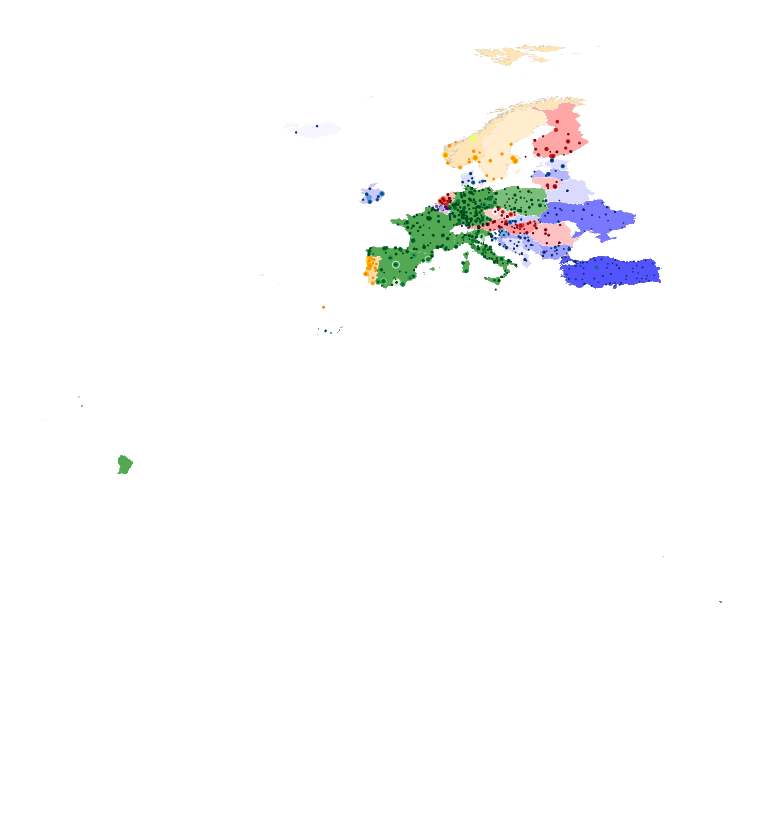

In [26]:
colors = ['red', 'blue', 'green', 'orange', 'purple']
cmaps = ['Reds_r', 'Blues_r', 'Greens_r', 'Wistia_r', 'Purples_r']

fig, ax = plt.subplots(figsize=(20,15))

for c in range(5):
    temp_df = geo_scores[geo_scores['Community'] == c].copy()
    temp_df = gpd.GeoDataFrame(temp_df, geometry = 'geometry')
    temp_df.plot(ax=ax, edgecolor='0.5', linewidth=0.3, color=colors[c], alpha=0.01)
    ax.scatter(x=temp_df['lng'], y=temp_df['lat'], s=temp_df['PageRank hub']*10**4, c=temp_df['PageRank hub'],
                  cmap=cmaps[c])
ax.axis('off')

# plt.savefig('countries_communities & universities_hubs.png')


In [ ]:
import networkx as nx

### 1 create the network of countries only
country_df = c_df[c_df[c_df.columns[10]]=='Learner']
country_df = country_df.loc[:, c_df.columns[np.array((14, 17, 20))]]
country_df.dropna(how='any', inplace=True)

# c_nodes = np.array(list(set.union(set(country_df.loc[:, country_df.columns[0]]), set(country_df.loc[:, country_df.columns[1]]))))
c_nodes = np.array(list(pd.concat([country_df.loc[:, country_df.columns[0]], country_df.loc[:, country_df.columns[1]]]).drop_duplicates()))
country_df.dropna(how='any', inplace=True)

c_node_position = {}
for i, name in enumerate(c_nodes):
    c_node_position[name] = i
country_nodes= pd.DataFrame({'Nodes': c_nodes})
country_df['SendId'] = (np.array(list(map(lambda x: c_node_position[x], country_df['Sending Country Code']))))
country_df['RecId'] = (np.array(list(map(lambda x: c_node_position[x], country_df['Receiving Country Code']))))
# Adjacency matrix
country_serie = country_df.groupby(['SendId', 'RecId']).sum()
row = np.array(country_serie.index.get_level_values(1).tolist())
col = np.array(country_serie.index.get_level_values(0).tolist())
val = country_serie.values
c_adj_matrix = sparse.csr_matrix((val.flatten(), (row, col)), shape=(c_nodes.size, c_nodes.size))

### 2 countries community
G_country = nx.convert_matrix.from_scipy_sparse_matrix(c_adj_matrix, create_using= nx.DiGraph)
p_c = nx.algorithms.community.modularity_max.greedy_modularity_communities(G_country)
country_comm = country_nodes.copy()

country_comm['Community']=np.zeros(len(country_comm.index),dtype='int8')
for i, set in enumerate(p_c):
    for element in set:
        country_comm.iat[element, 1]=i
for i, set in enumerate(p_c):
    display(country_comm[country_comm['Community']==i])

geo_scores = pd.merge(left=geo_scores, right=country_comm, how='left', left_on='iso2', right_on='Nodes')

In [ ]:
eu_countries = ['Germany', 'United Kingdom', 'France', 'Italy', 'Spain', 'Ukraine', 'Poland', 'Romania', 
                'Netherlands', 'Belgium', 'Czechia', 'Greece', 'Portugal', 'Sweden', 'Hungary', 
                'Belarus', 'Austria', 'Serbia', 'Switzerland', 'Bulgaria', 'Denmark', 'Finland', 'Slovakia', 'Norway',
                'Ireland', 'Croatia', 'Moldova', 'Bosnia and Herzegovina', 'Albania', 'Lithuania', 'Macedonia', 
                'Slovenia', 'Latvia', 'Estonia', 'Montenegro', 'Luxembourg', 'Malta', 'Iceland', 'Andorra', 'Monaco', 
                'Liechtenstein', 'Kosovo', 'Turkey']

def replace_iso3166(alpha):
    try:
        return pc.countries.get(name=alpha).alpha_2
    except:
        return alpha
    
eu_countries_iso2 = list(map(lambda x: replace_iso3166(x), eu_countries))

geo_scores = geo_scores[geo_scores['iso2'].isin(eu_countries_iso2)]

In [ ]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow']
cmaps = ['Reds_r', 'Blues_r', 'Greens_r', 'Wistia_r', 'Purples_r', 'YlGn']

fig, ax = plt.subplots(figsize=(20,15))

for c in range(5):
    temp_df = geo_scores[geo_scores['Community'] == c].copy()
    temp_df = gpd.GeoDataFrame(temp_df, geometry = 'geometry')
    temp_df.plot(ax=ax, edgecolor='0.5', linewidth=0.3, color=colors[c], alpha=0.01)
    ax.scatter(x=temp_df['lng'], y=temp_df['lat'], s=temp_df['PageRank hub']*10**4, c=temp_df['PageRank hub'],
                  cmap=cmaps[c])
ax.axis('off')

# plt.savefig('countries_communities & universities_hubs.png')


### Universities communities geographic plot

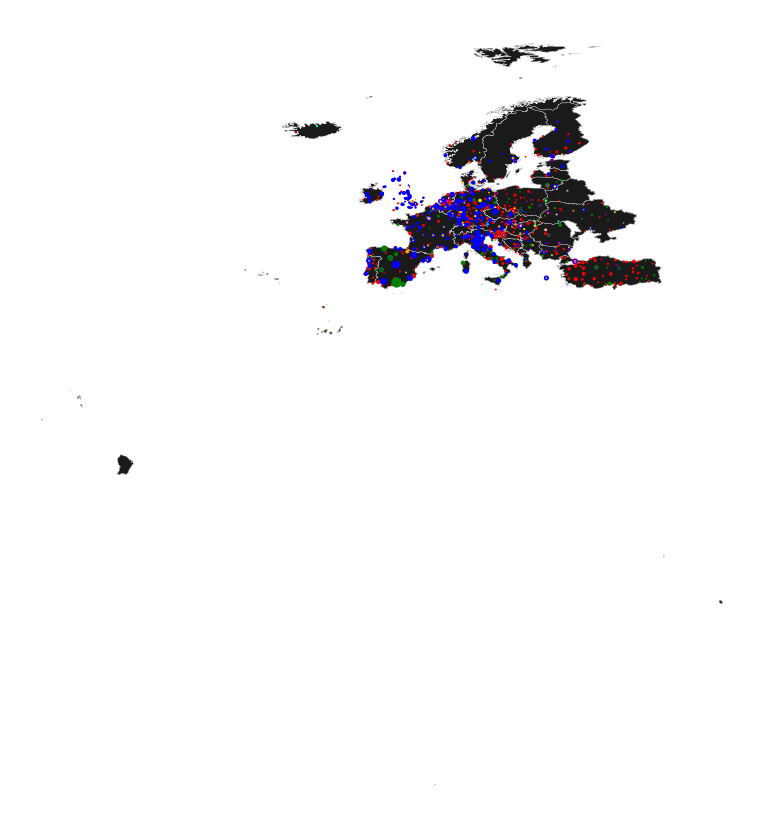

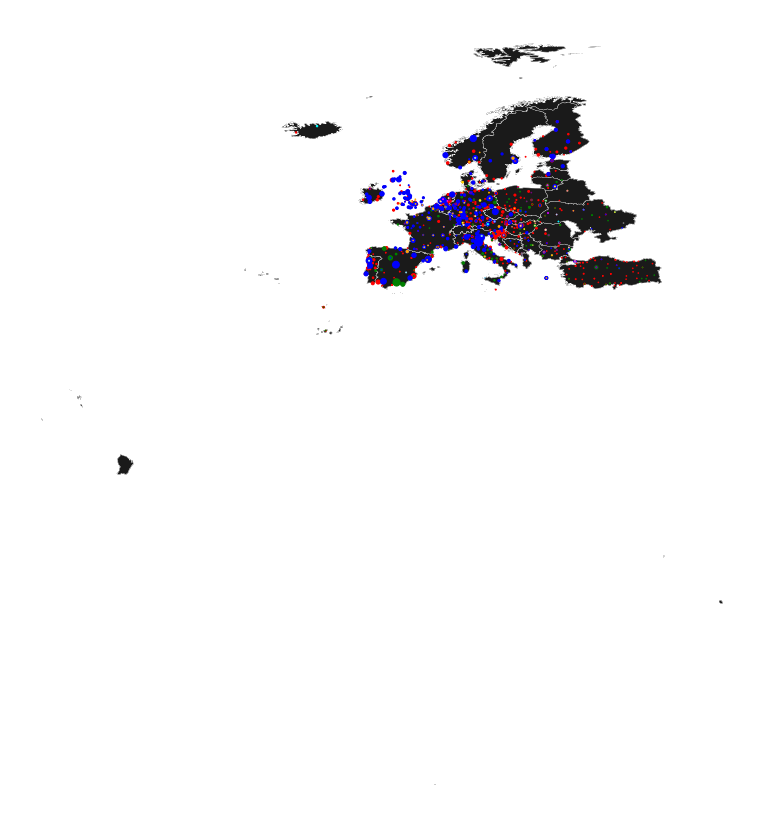

In [33]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'grey', 'gold', 'aqua', 'fuchsia', 'pink', 'yellow', 'salmon', 
          'khaki', 'brown', 'lime', 'skyblue', 'peachpuff', 'ivory', 'powderblue', 'rosybrown', 'royalblue', 
          'saddlebrown', 'salmon', 'sandybrown', 'seagreen', 'seashell', 'sienna', 'silver', 'skyblue', 'slateblue',
          'slategray', 'snow', 'springgreen', 'steelblue', 'tan', 'teal', 'thistle', 'tomato', 'turquoise', 'violet',
          'wheat', 'white', 'whitesmoke', 'yellow', 'yellowgreen', 'lightgreen', 'lightgray', 'lightpink', 'lightsalmon', 
          'lightseagreen', 'lightskyblue', 'lightslategray']

geo_plt = geo_scores.copy()
# dropping all communities containing number of universities lower or equal than 2
for c in range(max(geo_plt['uni_Community'])):
    if geo_plt[geo_plt['uni_Community'] == c].shape[0] <= 2:
        geo_plt = geo_plt[geo_plt['uni_Community'] != c]
geo_plt = gpd.GeoDataFrame(geo_plt, geometry='geometry')

# universities sized on PageRank hub score
fig, ax = plt.subplots(figsize=(20,15))

geo_plt.plot(ax=ax, edgecolor='1', linewidth=0.3, color='0.1')

# sns.scatterplot(x='lng', y='lat', data=geo_plt, hue='uni_Community', legend=False, ax=ax, size=geo_plt['PageRank hub']*10**4)
# ax.scatter(x=geo_plt['lng'], y=geo_plt['lat'], s=geo_plt['PageRank hub']*10**4, c=geo_plt['uni_Community'], cmap='jet')

for c in list(geo_plt['uni_Community'].unique()):
    temp_df = geo_plt[geo_plt['uni_Community'] == c].copy()
    temp_df = gpd.GeoDataFrame(temp_df, geometry = 'geometry')
    # ax.scatter(x=temp_df['lng'], y=temp_df['lat'], s=temp_df['PageRank hub']*10**4, c=temp_df['uni_Community'], cmap='Pastel1')
    # ax.scatter(x=temp_df['lng'], y=temp_df['lat'], s=temp_df['PageRank hub']*10**4, cmap='Pastel1')
    # ax.scatter(x=temp_df['lng'], y=temp_df['lat'], s=temp_df['PageRank hub']*10**4, c=temp_df['uni_Community'])
    ax.scatter(x=temp_df['lng'], y=temp_df['lat'], s=temp_df['PageRank hub']*10**4, color=colors[c])
ax.axis('off')

# plt.savefig('universities_communities_hubs.png')

# universities sized on PageRank authority score
fig, ax = plt.subplots(figsize=(20,15))

geo_plt.plot(ax=ax, edgecolor='1', linewidth=0.3, color='0.1')

for c in list(geo_plt['uni_Community'].unique()):
    temp_df = geo_plt[geo_plt['uni_Community'] == c].copy()
    temp_df = gpd.GeoDataFrame(temp_df, geometry = 'geometry')
    ax.scatter(x=temp_df['lng'], y=temp_df['lat'], s=temp_df['PageRank autority']*10**4, color=colors[c])
ax.axis('off')

# plt.savefig('universities_communities_authorities.png')

### Robustness

In [28]:
#attack: removing hubs first
nodes_byhub = scores.sort_values('PageRank hub', ascending=False)['NodeID']
indices = list(nodes_byhub)
uni_df = mobility_df.copy()
GC_frac_a = [1]
for node in indices:
    uni_df = uni_df.loc[(uni_df['sourceID'] != node) & (uni_df['targetID'] != node)]
    temp_serie = uni_df.groupby(['sourceID', 'targetID']).sum()
    row = np.array(temp_serie.index.get_level_values(1).tolist())
    col = np.array(temp_serie.index.get_level_values(0).tolist())
    val = temp_serie.values
    temp_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
    GC_frac_a.append(ns.fraction_in_giant(temp_adj))


In [29]:
#random node removal
import random
#10 by 10, with average over 10 trials each time
intervals = list(range(10, len(nodes_byhub+1), 10))
uni_df = mobility_df.copy()
GC_frac_r = [1]
for i in intervals:
    i_GC_frac = []
    for j in range(10):
        removed = random.sample(indices, i)
        temp_df = uni_df.loc[~(uni_df['sourceID'].isin(removed) | (uni_df['targetID'].isin(removed)))]
        temp_serie = temp_df.groupby(['sourceID', 'targetID']).sum()
        row = np.array(temp_serie.index.get_level_values(1).tolist())
        col = np.array(temp_serie.index.get_level_values(0).tolist())
        val = temp_serie.values
        temp_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
        i_GC_frac.append(ns.fraction_in_giant(temp_adj))
    GC_frac_r.append(sum(i_GC_frac)/10)

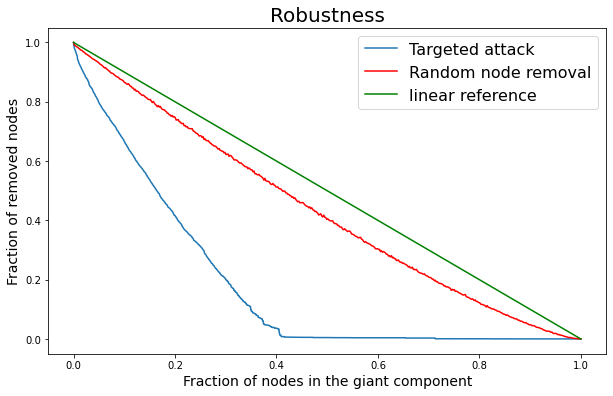

In [30]:
fig = plt.figure(figsize=(10,6))
plt.plot([i/len(nodes_byhub) for i in range(len(nodes_byhub)+1)], GC_frac_a, label='Targeted attack')
plt.plot([0]+[i/(len(intervals)*10) for i in intervals], GC_frac_r, 'r', label='Random node removal')
plt.plot([0,1], [1,0], 'g', label='linear reference')
plt.xlabel('Fraction of nodes in the giant component', size=14)
plt.ylabel('Fraction of removed nodes', size=14)
plt.title('Robustness', size=20)
plt.legend(fontsize=16)
plt.show()